In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## 합성곱 층

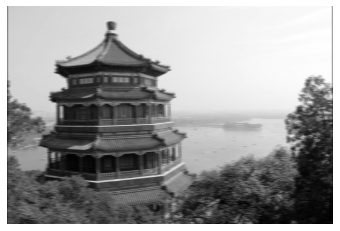

In [3]:
from sklearn.datasets import load_sample_image

# load image
# 각 컬러 채널의 픽셀 강도는 0에서 255 사의 값 바이트 하나로 표현되기 때문에 255를 나우어서 0과 1사이의 실수로 만들어줌
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# 2개의 필터
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray")
plt.axis("off")
plt.show()

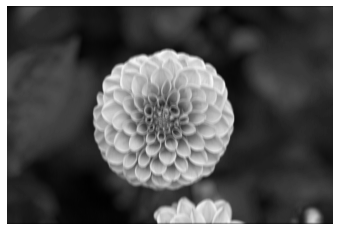

In [4]:
plt.imshow(outputs[1, :, :, 0], cmap="gray")
plt.axis("off")
plt.show()

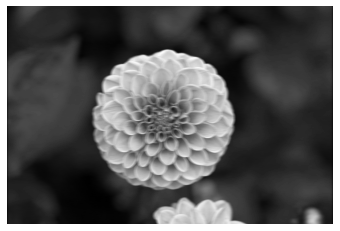

In [5]:
plt.imshow(outputs[1, :, :, 1], cmap="gray")
plt.axis("off")
plt.show()

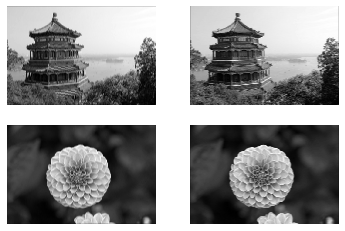

In [6]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])
        
plt.show()

In [7]:
def crop(images):
    return images[150:220, 130:250]

그림 저장 china_original


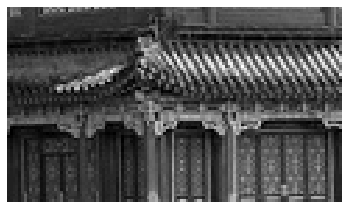

그림 저장 china_vertical


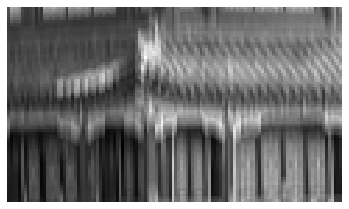

그림 저장 china_horizontal


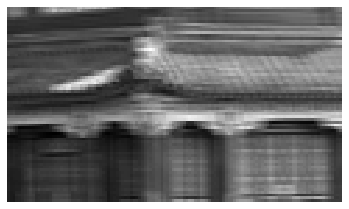

In [8]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

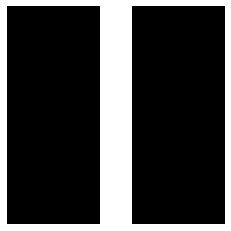

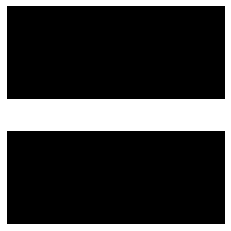

In [9]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

In [10]:
# keras.layers.Conv2D()
np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                          padding="SAME", activation="relu", input_shape=outputs.shape)

In [11]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

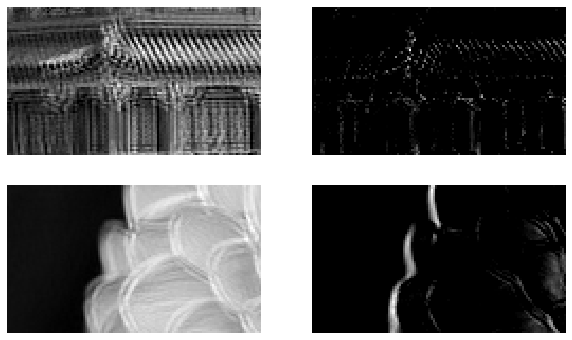

In [12]:
plt.figure(figsize=(10, 6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

In [13]:
conv.set_weights([filters, np.zeros(2)])

In [14]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

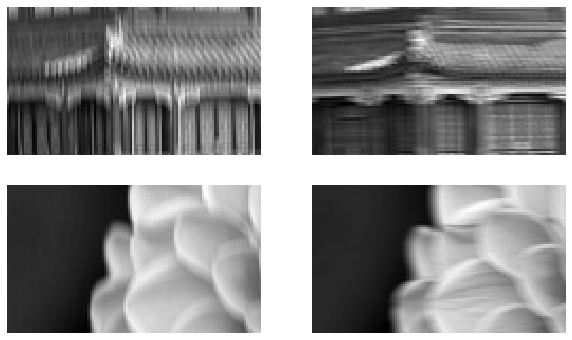

In [15]:
plt.figure(figsize=(10, 6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

In [16]:
# VALID vs SAME 패팅
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [17]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [18]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_heigth = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_heigth, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

In [19]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="valid")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# conv_same의 가중치를 생성하기 위해 build() 매서드 호출
conv_same.build(tf.TensorShape(images.shape))

# conv_valid의 가중치를 conv_same으로 복사
conv_same.set_weights(conv_valid.get_weights())
same_output = conv_same(images.astype(np.float32))
assert np.allclose(valid_output.numpy(), same_output.numpy())

## 풀링 층

In [20]:
# 최대 풀링
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [21]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

그림 저장 china_max_pooling


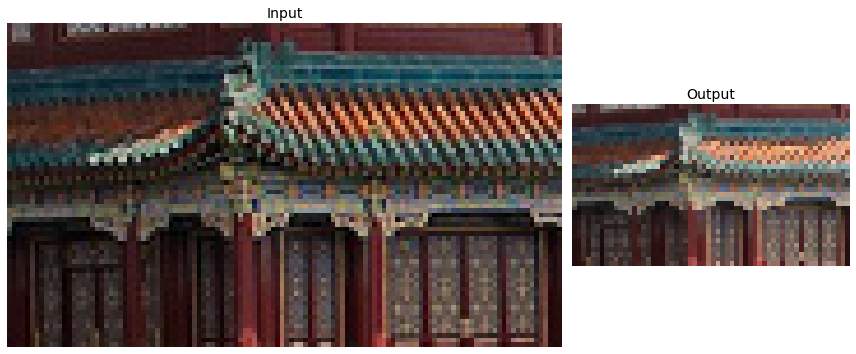

In [22]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

In [23]:
# 깊이 방향 풀링
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs, 
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [24]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

In [25]:
# Lambda층 사용
depth_pool = keras.layers.Lambda(lambda X:tf.nn.max_pool(
X,ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

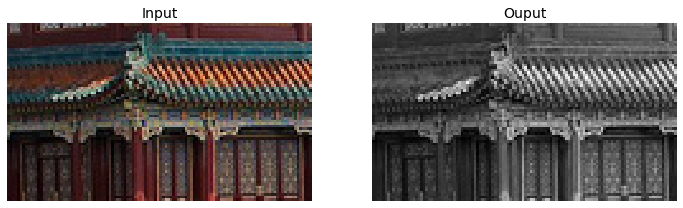

In [26]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])
plt.subplot(1, 2, 2)
plt.title("Ouput", fontsize=14)
plot_image(depth_output[0, ..., 0])
plt.axis("off")
plt.show()

In [27]:
# 평균 폴링
avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_avg = avg_pool(cropped_images)

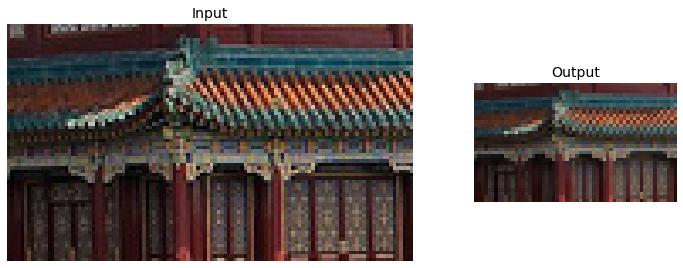

In [28]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])
ax2.axis("off")
plt.show()

In [29]:
# 전역 평균 풀링
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

In [30]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

### CNN으로 패션 MNIST 문제 풀기

In [31]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4431872/4422102 [==============================] - 0s 0us/step


In [32]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [33]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # 새로운 이미지처럼 사용합니다
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 42s 22ms/step - loss: 0.7344 - accuracy: 0.7406 - val_loss: 0.4038 - val_accuracy: 0.8530
Epoch 2/10
1719/1719 [==============================] - 45s 26ms/step - loss: 0.4316 - accuracy: 0.8546 - val_loss: 0.3525 - val_accuracy: 0.8744
Epoch 3/10
1719/1719 [==============================] - 44s 26ms/step - loss: 0.3696 - accuracy: 0.8756 - val_loss: 0.3158 - val_accuracy: 0.8894
Epoch 4/10
1719/1719 [==============================] - 44s 26ms/step - loss: 0.3353 - accuracy: 0.8865 - val_loss: 0.2906 - val_accuracy: 0.8968
Epoch 5/10
1719/1719 [==============================] - 43s 25ms/step - loss: 0.3119 - accuracy: 0.8944 - val_loss: 0.3201 - val_accuracy: 0.8870
Epoch 6/10
1719/1719 [==============================] - 43s 25ms/step - loss: 0.2920 - accuracy: 0.9004 - val_loss: 0.2818 - val_accuracy: 0.8952
Epoch 7/10
1719/1719 [==============================] - 45s 26ms/step - loss: 0.2836 - accuracy: 0.9035 - val_loss: 0.2741 -

In [34]:
# ResNet-34

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
  def __init__(self, filters, strides=1, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.main_layers = [
                        DefaultConv2D(filters, strides=strides),
                        keras.layers.BatchNormalization(),
                        self.activation,
                        DefaultConv2D(filters),
                        keras.layers.BatchNormalization()]
    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [
                          DefaultConv2D(filters, kernel_size=1, strides=strides),
                          keras.layers.BatchNormalization()]

  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [35]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74240     
 )                                                               
                                                      

In [37]:
# 사전 훈련된 모델 사용하기
# 사전 훈련된 ResNet-50모델
# ResNet-50모델을 만들고 이미지넷 데이터셋에서 사전훈련된 가중치를 다운로드
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102981632/102967424 [==============================] - 2s 0us/step


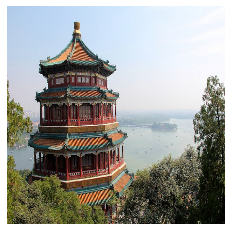

In [38]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


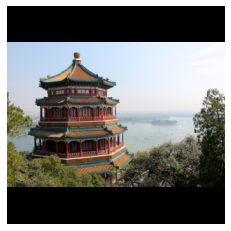

In [39]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

In [40]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

In [41]:
Y_proba = model.predict(inputs)

In [42]:
Y_proba.shape

(2, 1000)

In [43]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
  print("Image #{}".format(image_index))
  for class_id, name, y_proba in top_K[image_index]:
    print(" {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
  print()

49152/35363 [=========================================] - 0s 0us/step
Image #0
 n03028079 - church       26.16%
 n04346328 - stupa        23.96%
 n02980441 - castle       17.40%

Image #1
 n11939491 - daisy        15.94%
 n03530642 - honeycomb    15.29%
 n04522168 - vase         9.32%



In [44]:
top_K

[[('n03028079', 'church', 0.26161626),
  ('n04346328', 'stupa', 0.23955683),
  ('n02980441', 'castle', 0.17399566)],
 [('n11939491', 'daisy', 0.1594153),
  ('n03530642', 'honeycomb', 0.15285257),
  ('n04522168', 'vase', 0.09315201)]]

In [45]:
# 사전훈련된 모데을 사용한 전이 학습

import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [46]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [47]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=3670>

In [48]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [49]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load("tf_flowers",
                                                       split=["train[:10%]", "train[10%:25%]", "train[25%:]"], # 10, 15, 75
                                                       as_supervised=True)

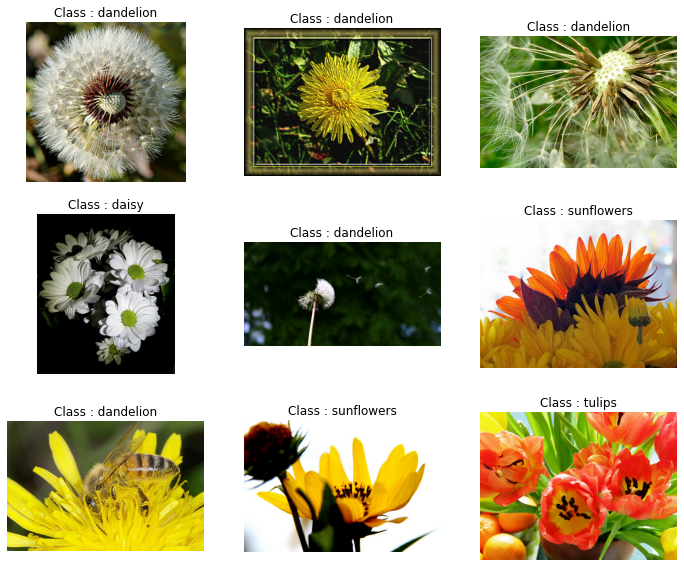

In [50]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
  index += 1
  plt.subplot(3, 3, index)
  plt.imshow(image)
  plt.title("Class : {}".format(class_names[label]))
  plt.axis("off")
plt.show()

In [51]:
def preprocessing(image, label):
  resized_image = tf.image.resize(image, [224, 255])
  final_image = keras.applications.xception.preprocess_input(reduce_image)
  return final_image, label
                                  

In [52]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [53]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

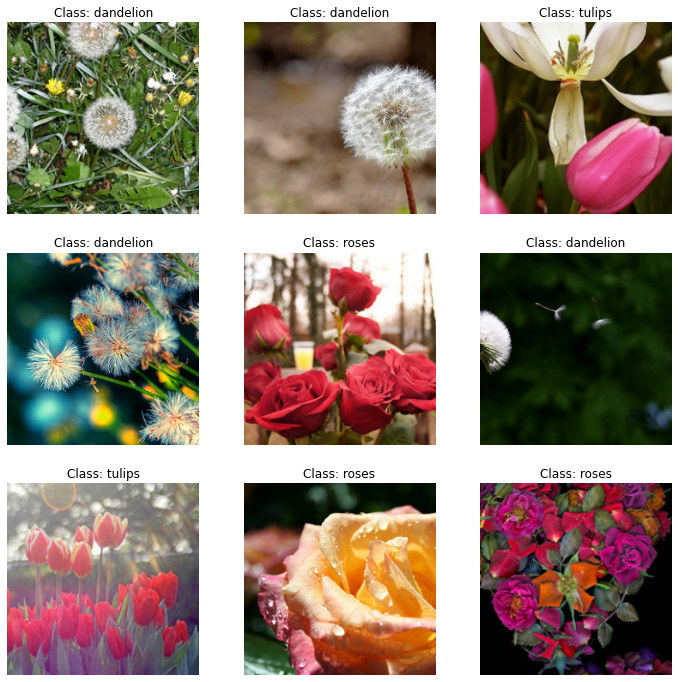

In [54]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
  for index in range(9):
    plt.subplot(3, 3, index + 1)
    plt.imshow(X_batch[index] / 2 + 0.5)
    plt.title("Class: {}".format(class_names[y_batch[index]]))
    plt.axis("off")
plt.show()

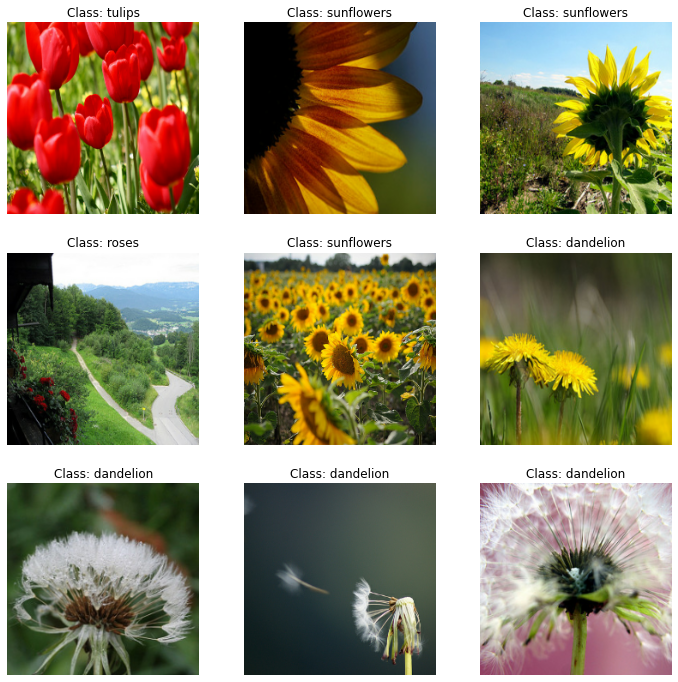

In [55]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
  for index in range(9):
    plt.subplot(3, 3, index + 1)
    plt.imshow(X_batch[index] / 2 + 0.5)
    plt.title("Class: {}".format(class_names[y_batch[index]]))
    plt.axis("off")
plt.show()


In [56]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83697664/83683744 [==============================] - 1s 0us/step


In [57]:
for index, layer in enumerate(base_model.layers):
  print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_44
13 block2_pool
14 batch_normalization_36
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_45
23 block3_pool
24 batch_normalization_37
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_46
33 block4_pool
34 batch_normalization_38
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [58]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 45s 413ms/step - loss: 1.4720 - accuracy: 0.7925 - val_loss: 1.4752 - val_accuracy: 0.8070
Epoch 2/5
86/86 [==============================] - 34s 393ms/step - loss: 0.6576 - accuracy: 0.8914 - val_loss: 0.9815 - val_accuracy: 0.8732
Epoch 3/5
86/86 [==============================] - 34s 393ms/step - loss: 0.3623 - accuracy: 0.9248 - val_loss: 0.8554 - val_accuracy: 0.8732
Epoch 4/5
86/86 [==============================] - 34s 394ms/step - loss: 0.2582 - accuracy: 0.9335 - val_loss: 0.7072 - val_accuracy: 0.8842
Epoch 5/5
86/86 [==============================] - 34s 394ms/step - loss: 0.2029 - accuracy: 0.9440 - val_loss: 0.7266 - val_accuracy: 0.8732


In [59]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 42s 413ms/step - loss: 0.3267 - accuracy: 0.9230 - val_loss: 0.8471 - val_accuracy: 0.8658
Epoch 2/5
86/86 [==============================] - 34s 393ms/step - loss: 0.2163 - accuracy: 0.9415 - val_loss: 0.8225 - val_accuracy: 0.8548
Epoch 3/5
86/86 [==============================] - 34s 394ms/step - loss: 0.1761 - accuracy: 0.9466 - val_loss: 0.6757 - val_accuracy: 0.8879
Epoch 4/5
86/86 [==============================] - 34s 394ms/step - loss: 0.1482 - accuracy: 0.9578 - val_loss: 0.6869 - val_accuracy: 0.8768
Epoch 5/5
86/86 [==============================] - 34s 394ms/step - loss: 0.1372 - accuracy: 0.9557 - val_loss: 0.6916 - val_accuracy: 0.8787


In [59]:
for layer in base_model.layers:
  layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossenropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_stage=int(0.15 * dataset_size / batch_size),
                    epochs=40)

In [61]:
# 분류와 위치 추정
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],
              optimizer=optimizer, metrics=["accuracy"])

In [64]:
# 이미지 바운딩 박스
def add_random_bounding_boxes(images, labels):
  fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
  return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [65]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 18s 1s/step - loss: 1.2615 - dense_7_loss: 1.4973 - dense_8_loss: 0.3184 - dense_7_accuracy: 0.3688 - dense_8_accuracy: 0.2875
Epoch 2/2
5/5 [==============================] - 7s 1s/step - loss: 0.8661 - dense_7_loss: 1.0083 - dense_8_loss: 0.2972 - dense_7_accuracy: 0.7000 - dense_8_accuracy: 0.1813
